In [ ]:
import tensorflow as tf
import PIL
import  numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
path='/content/drive/MyDrive/kaggle_3m/kaggle_3m'

def read_data_point(data_point):
    img_path,mask_path=data_point
    img=PIL.Image.open(img_path)
    mask=PIL.Image.open(mask_path)
    img=np.asarray(img)
    mask=np.asarray(mask)
    return (img,mask)

        
def load_dataset(PATH):
    list_img_path,list_mask_path=list(),list()
    list_img,list_mask=list(),list()
    for roots,dirs,files in os.walk(PATH):
        for name in files:
            file_path=os.path.join(roots,name)
            if name.find('mask')!=-1:
                list_mask_path.append(file_path)
            elif name[-3:]=='tif':
                list_img_path.append(file_path)
    list_img_path.sort()
    list_mask_path.sort()
    i=0
    for data_point in zip(list_img_path,list_mask_path):
        img,marsk=read_data_point(data_point)
        
        list_img.append(img)
        list_mask.append(marsk)
        i=i+1
        if i%1000 ==0:
          print('loaded {} data_point'.format(i))
    return np.asarray(list_img),np.asarray(list_mask)
        
#image,mask=load_dataset(path)
#np.savez(os.path.join(path,'/content/drive/MyDrive/kggle_3m.npz'),image=image, mask=mask)

data=np.load(r'/content/drive/MyDrive/Dataset/kggle_3m.npz')
img,mask=data['image'],data['mask']

In [ ]:

from numpy import asarray
def make_label(mask):
  new_mask=np.copy(mask)
  new_mask[new_mask==255]=2
  new_mask[new_mask>2]=1
  return new_mask

def normalize(image, mask,required_size=(128,128)):
 

  list_image,list_mask=[],[]
  for i in zip(image,mask):
    new_image=asarray( PIL.Image.fromarray(i[0]).resize((required_size)) ,'float32')/255.0
    new_mask=asarray(PIL.Image.fromarray(i[1]).resize((required_size)))

    new_mask=make_label(new_mask)
    
    new_mask=np.expand_dims(new_mask,axis=-1)

    list_image.append(new_image)
    list_mask.append(new_mask)

  return asarray(list_image) , asarray(list_mask)


In [ ]:
img,mask=normalize(img,mask)

In [ ]:
print(len(img))
print(len(mask))
print(mask[0].shape)

3929
3929
(128, 128, 1)


(128, 128, 1)


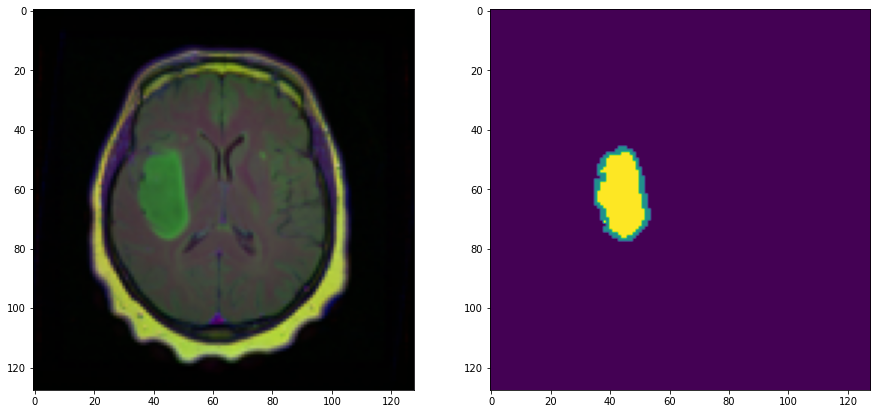

In [ ]:
plt.figure(figsize=(15,15))
title=['input image','input mask']

plt.subplot(1,2,1)
plt.imshow(img[25])

plt.subplot(1,2,2)
plt.imshow(np.squeeze(mask[25]))
print(mask[25].shape)

9412608/9406464 [==============================] - 0s 0us/step


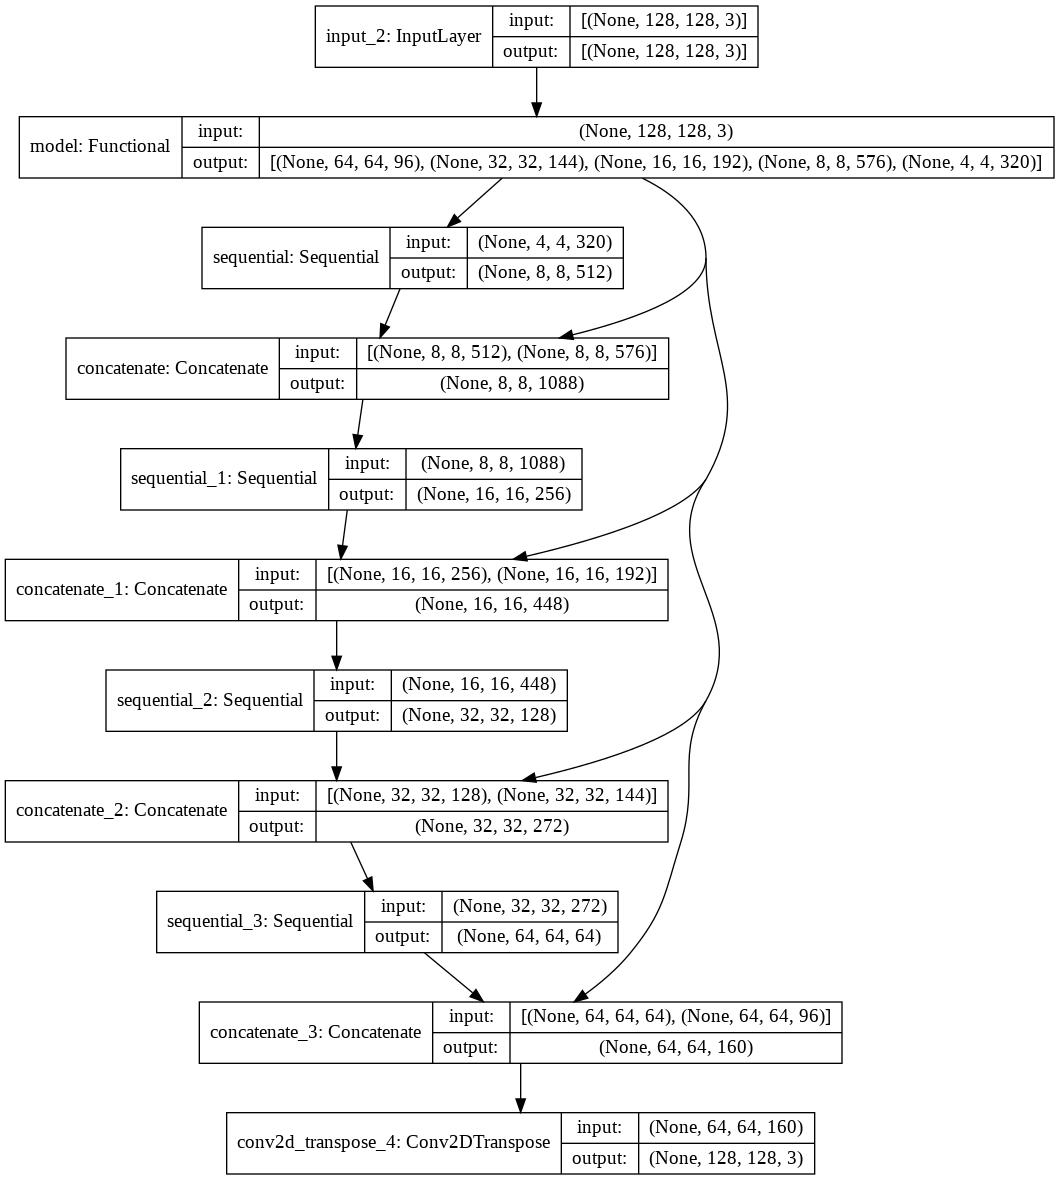

In [ ]:

OUTPUT_CHANNELS = 3
import tensorflow as tf


from IPython.display import clear_output
import matplotlib.pyplot as plt
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.03)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.2))

  result.add(tf.keras.layers.ReLU())

  return result


# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable =  False

up_stack = [
   
    upsample(512, 3,True),  # 4x4 -> 8x8
    upsample(256, 3,True),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None):

  pred_mask = model.predict(np.expand_dims(img[25],axis=0))

  plt.figure(figsize=(15,15))

  plt.subplot(1,3,1)
  plt.title('Trust Image')
  plt.imshow(img[25])

  plt.subplot(1,3,2)
  plt.title('Trust mask')
  plt.imshow(np.squeeze(mask[25],-1))

  plt.subplot(1,3,3)
  plt.title('Predict mask')
  plt.imshow(np.squeeze(create_mask(pred_mask),axis=-1))

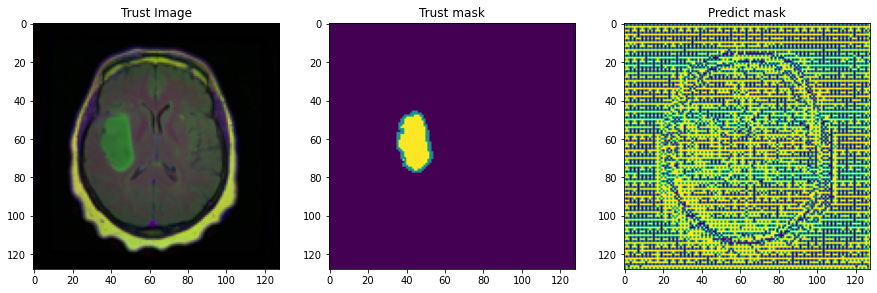

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
print(mask.shape)
print(img.shape)

(3929, 128, 128, 1)
(3929, 128, 128, 3)


Epoch 1/20
85/85 [==============================] - 11s 85ms/step - loss: 0.1400 - accuracy: 0.9627 - val_loss: 0.0733 - val_accuracy: 0.9860

Sample Prediction after epoch 1

Epoch 2/20
85/85 [==============================] - 7s 75ms/step - loss: 0.0439 - accuracy: 0.9897 - val_loss: 0.0456 - val_accuracy: 0.9871

Sample Prediction after epoch 2

Epoch 3/20
85/85 [==============================] - 6s 76ms/step - loss: 0.0268 - accuracy: 0.9924 - val_loss: 0.0361 - val_accuracy: 0.9896

Sample Prediction after epoch 3

Epoch 4/20
85/85 [==============================] - 6s 77ms/step - loss: 0.0237 - accuracy: 0.9928 - val_loss: 0.0355 - val_accuracy: 0.9901

Sample Prediction after epoch 4

Epoch 5/20
85/85 [==============================] - 7s 77ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.0304 - val_accuracy: 0.9910

Sample Prediction after epoch 5

Epoch 6/20
85/85 [==============================] - 7s 78ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0269 - val_

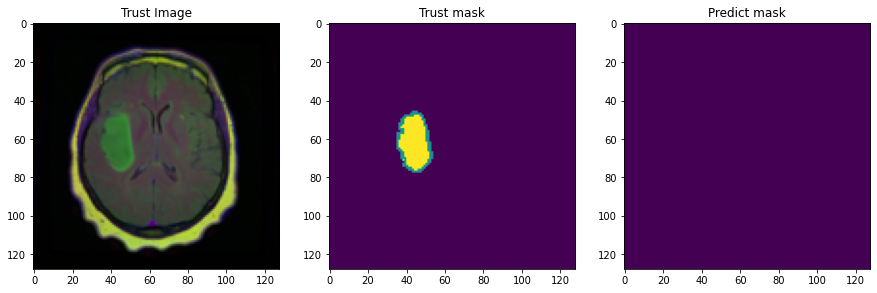

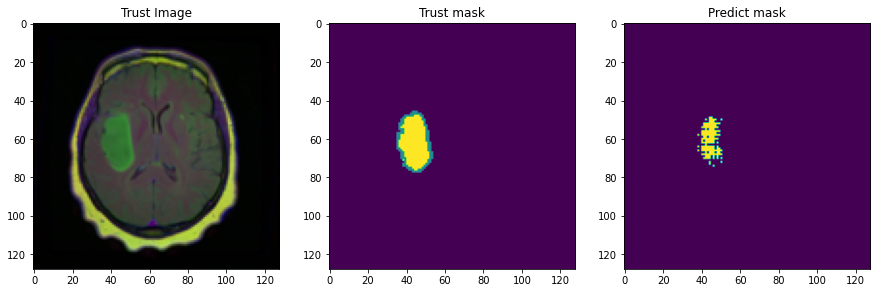

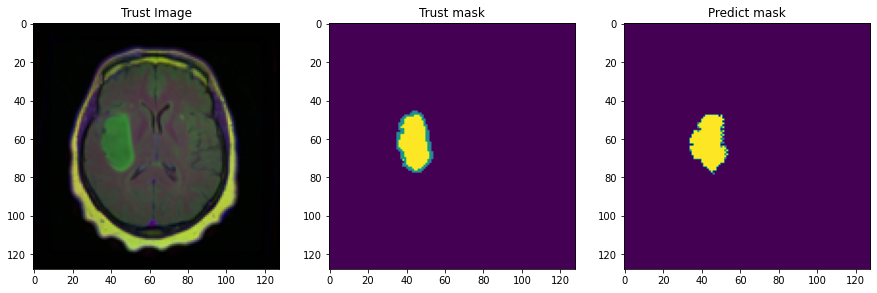

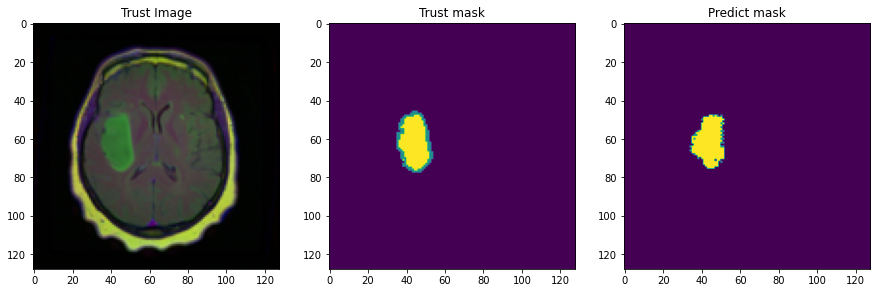

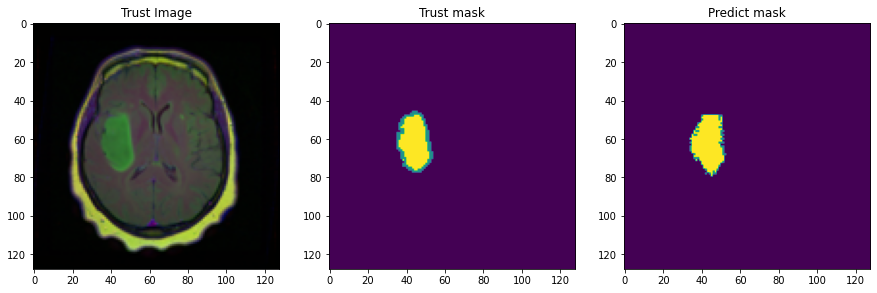

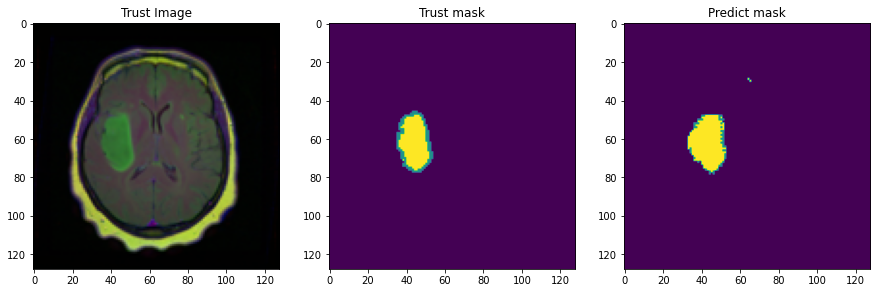

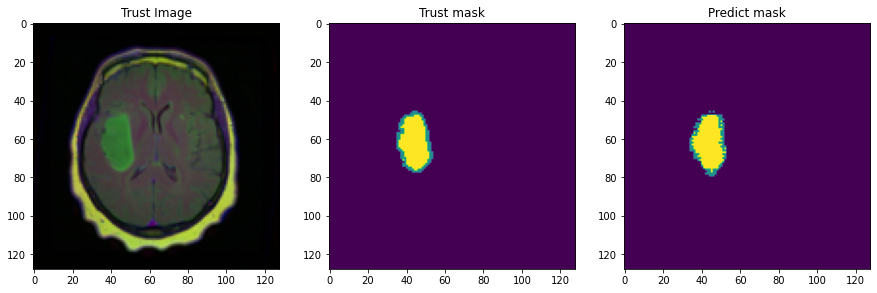

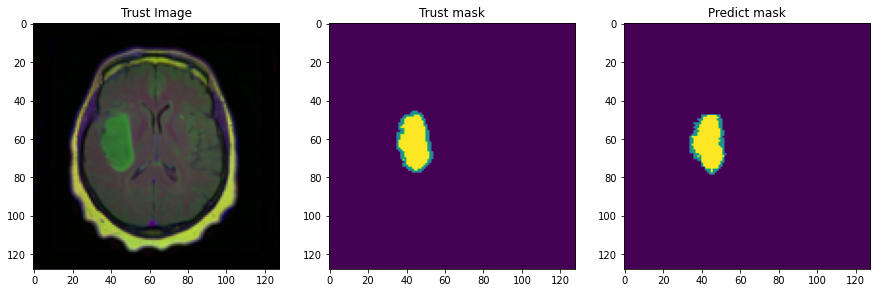

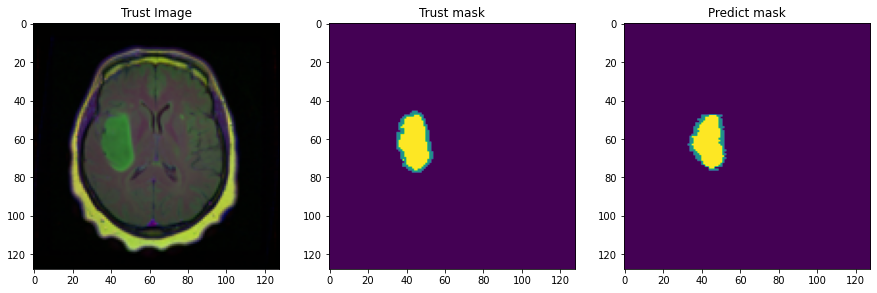

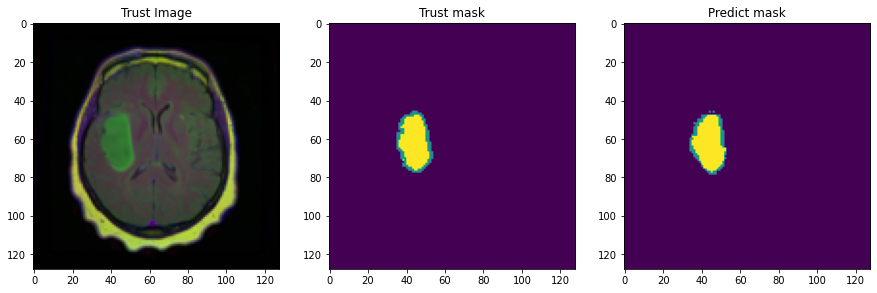

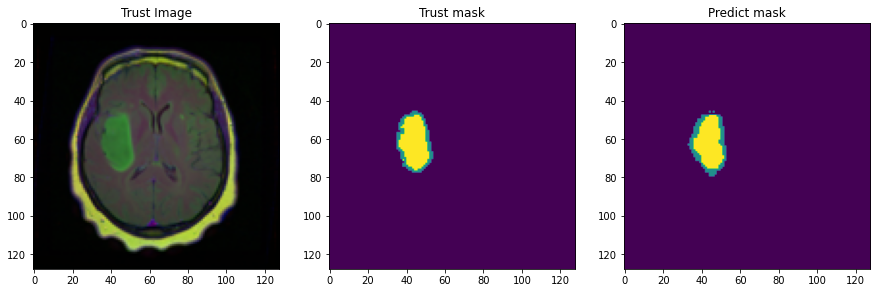

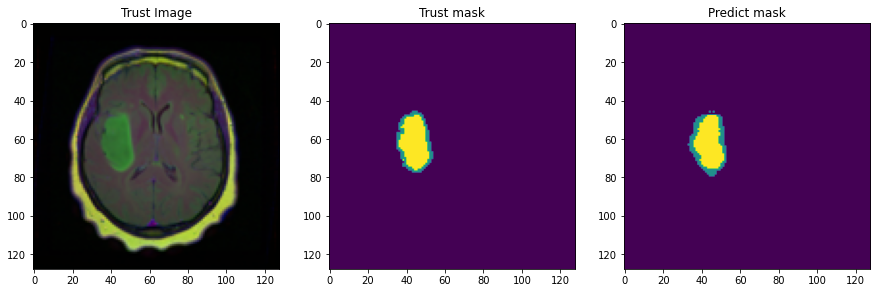

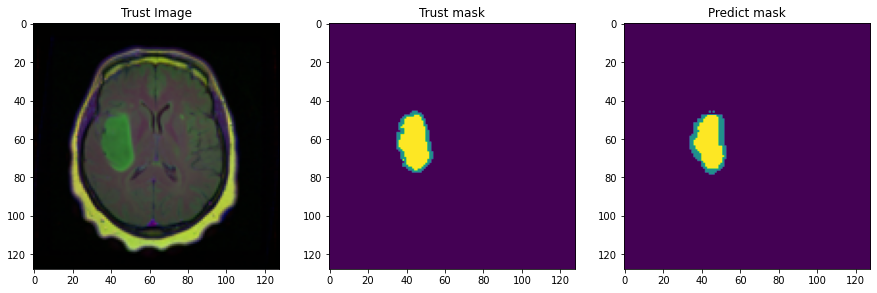

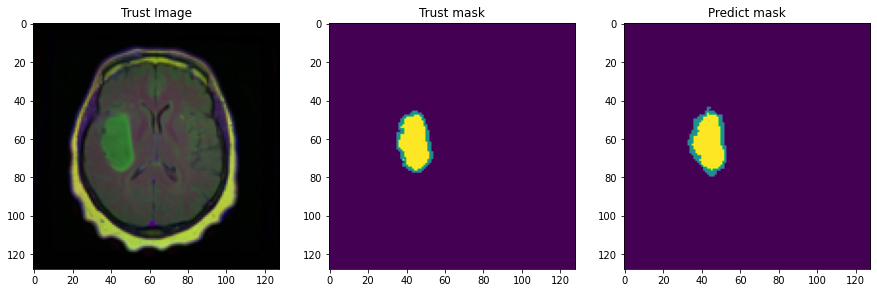

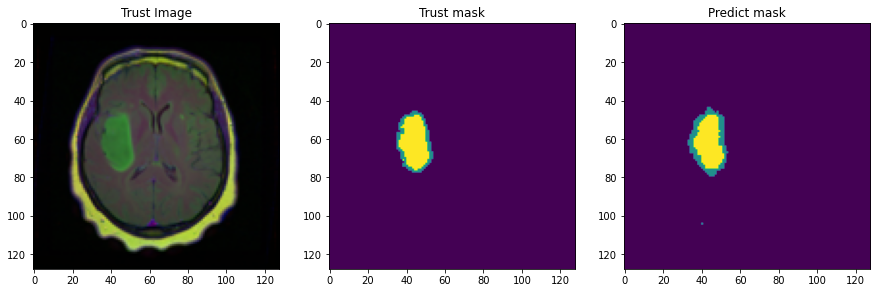

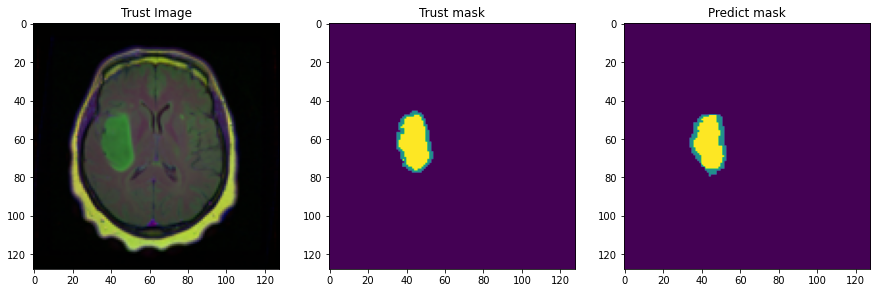

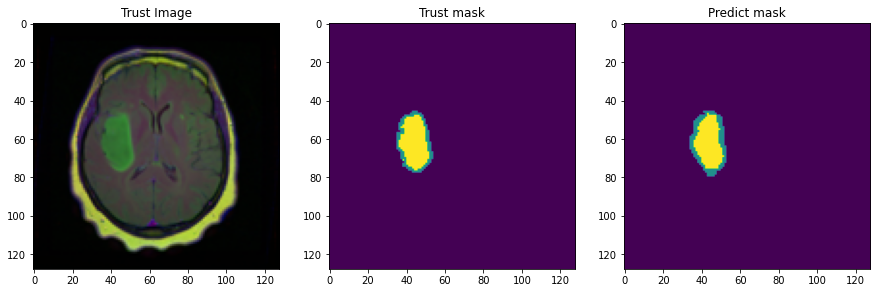

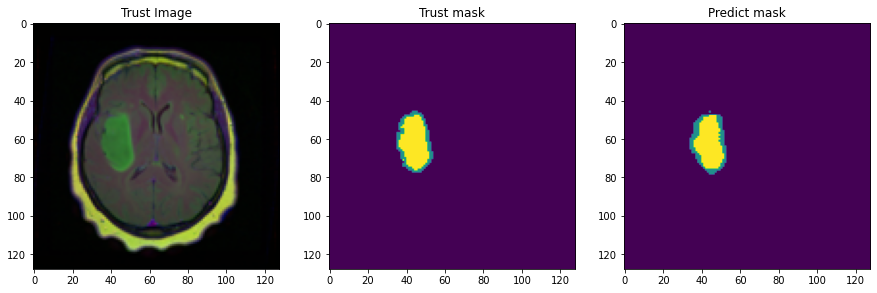

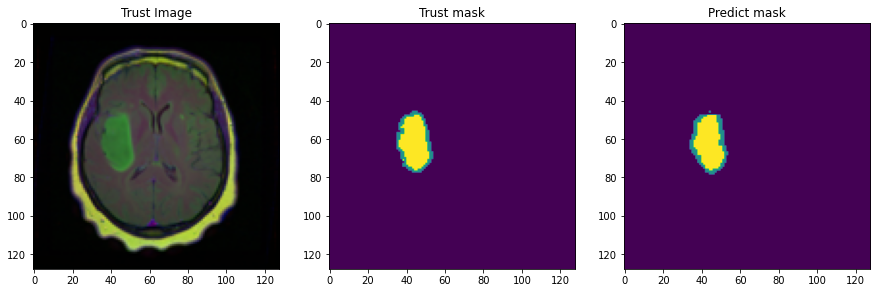

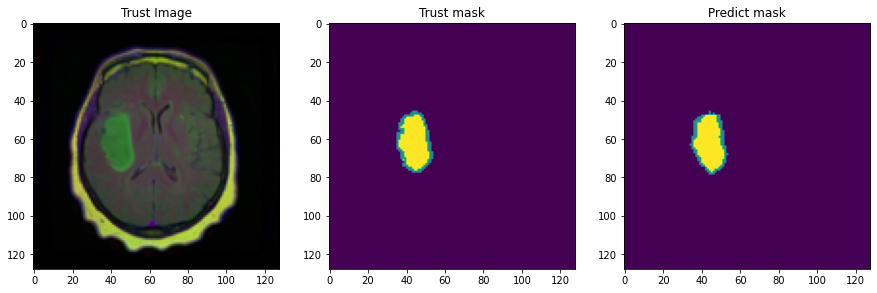

In [ ]:
EPOCHS = 20
BATCH_SIZE=32
VALIDATION_STEPS=len(img)//10*3//BATCH_SIZE
STEPS_PER_EPOUCH=len(img)//10*7//BATCH_SIZE

history=model.fit(
    x=img,
    y=mask,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose="auto",
    callbacks=[DisplayCallback()],
    validation_split=0.3,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=STEPS_PER_EPOUCH,
    validation_steps=VALIDATION_STEPS,
    validation_batch_size=BATCH_SIZE,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

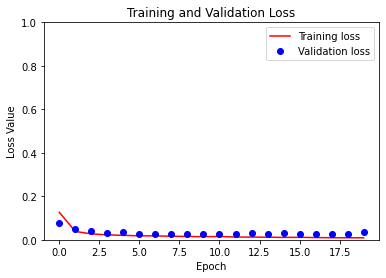

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
model.evaluate(x=img,y=mask)

123/123 [==============================] - 5s 41ms/step - loss: 0.0162 - accuracy: 0.9951


[0.016157962381839752, 0.9950689673423767]